# Tarea 3
- Nombre: **Matías Duhalde**
- Número de alumno: **18639496**


## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import face_recognition as fr

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

## Define constants

In [ ]:
EMOTIONS = {
    0: 'enojo',
    1: 'asco',
    2: 'miedo',
    3: 'alegría',
    4: 'tristeza',
    5: 'sorpresa',
    6: 'neutral',
}

IMAGE_WIDTH = 48
IMAGE_HEIGHT = 48

## Load dataset

In [ ]:
CSV_PATH = 'mini_fer2013.csv'

df = pd.read_csv(CSV_PATH)

## Parte 1

### Helper functions

In [ ]:
def string_to_picture_array(string_):
    pixels = [int(x) for x in string_.split(" ")]
    array = np.empty((IMAGE_HEIGHT, IMAGE_WIDTH), dtype='uint8')
    for i in range(IMAGE_HEIGHT):
        for j in range(IMAGE_WIDTH):
            array[i][j] = pixels[i*IMAGE_HEIGHT+j]
    return array

def picture_array_to_fr_image(array):
    return array


### Preprocessing

In [ ]:
print(df[['Usage']].value_counts(normalize=True))
print(df[['emotion']].value_counts(normalize=True))

# Pixels to array
df['pixels'] = df['pixels'].apply(string_to_picture_array)

# Emotion to label
df['emotion'] = df['emotion'].apply(lambda x: EMOTIONS[x])

Usage
ToV      0.900641
Test     0.099359
dtype: float64
emotion
3          0.368415
6          0.232284
5          0.122552
0          0.116900
4          0.085140
2          0.067890
1          0.006818
dtype: float64


### Get one sample image per emotion

In [ ]:
emotion_sample = []
for emotion in EMOTIONS.values():
    emotion_sample.append(df[df.emotion == emotion].iloc[1])

### Show images

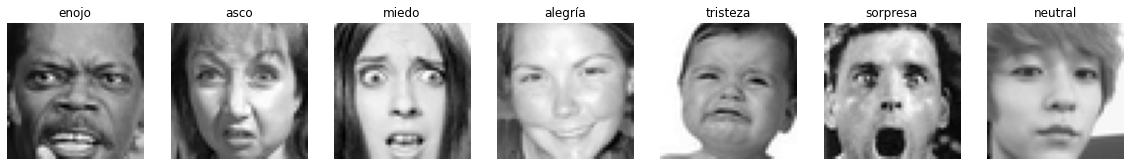

In [ ]:
fig, axs = plt.subplots(1, len(EMOTIONS))
fig.set_size_inches((20,4))

for i, row in enumerate(emotion_sample):
    axs[i].imshow(row['pixels'], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(row['emotion'])

### Face recognition (face_landmarks)

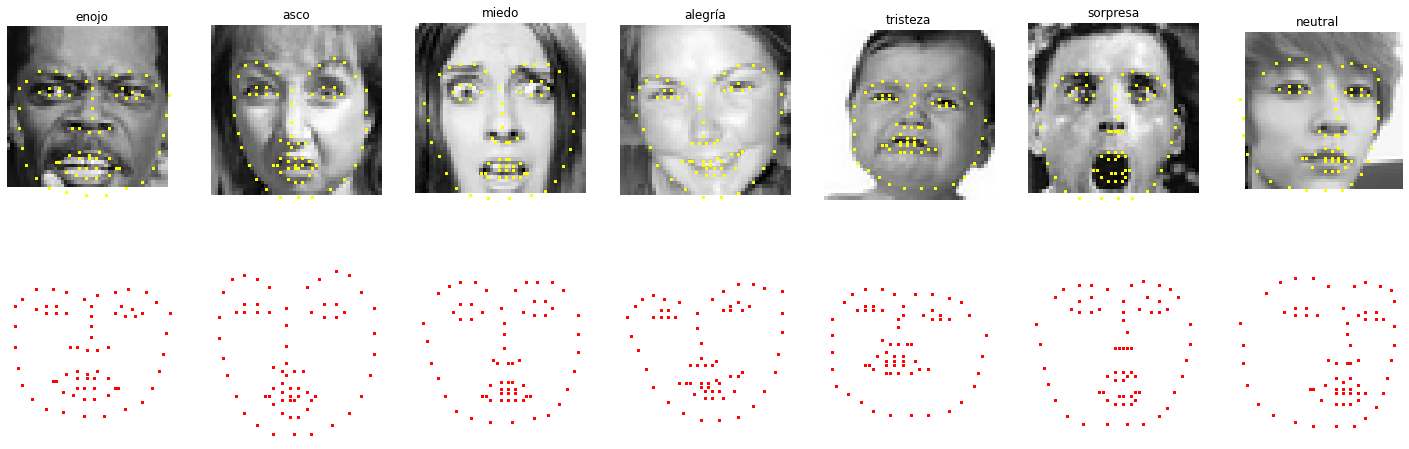

In [ ]:
fig, axs = plt.subplots(2, len(EMOTIONS))
fig.set_size_inches((25,8))

for i, row in enumerate(emotion_sample):
    image = row.pixels
    axs[0][i].imshow(row['pixels'], cmap='gray')
    axs[0][i].axis('off')
    axs[0][i].set_title(row['emotion'])
    res = fr.face_landmarks(image)
    if res:
        flatten = [item for sublist in res[0].values() for item in sublist]
        x, y = zip(*flatten)
        axs[0][i].scatter(x, y, 8, 'yellow', marker='s')
        axs[1][i].set_aspect('equal', adjustable='box')
        axs[1][i].axis('off')
        axs[1][i].invert_yaxis()
        axs[1][i].scatter(x, y, 8, 'red', marker='s')


## Parte 2

### Estrategia

El set de test ya venía predefinido según la columna **'Usage'** de los datos originales, y corresponde aproximadamente al $10\%$ de los datos. Por lo tanto, los sets de training y validación deben ser asignados a partir del $90\%$ restante.

Para decidir la proporción entre training y validación, se usó una proporción del $80\%$ y $10\%$ respectivamente. Este valor surge de las discusiones en clase y fuentes online, en donde se discute que una proporción aceptable y común entre el set de training y el resto, es del $70\%-30\%$, y el $70\%$ puede aumentar en proporción según la cantidad de datos etiquetados se dispongan.

Además, la separación de los datos entre el set de training y validación es completamente aleatoria, por lo que no debería estar influenciada por ningún otra causa derivada del orden original de las filas en el archivo.

### ¿Cuánto es el máximo de características que puede incluir en cada matriz X?


El máximo de características que se podría añadir es una por cada pixel de la imagen, es decir, $48 \times 48 = 2304$. Sin embargo, para este caso, usaremos el output del reconocimiento facial, que entrega un total de 37 puntos mapeando la imagen, con 2 coordenadas cada uno, resultando en $72 \times 2 = 144$ características.


In [ ]:
def flatten_landmarks(landmarks_dict):
    return [item for sublist in landmarks_dict.values() for item in sublist]

def get_bounds(tuples):
    min_x, max_x, min_y, max_y = None, None, None, None
    for tuple_ in tuples:
        curr_x = tuple_[0]
        if min_x is None or curr_x < min_x:
            min_x = curr_x
        if max_x is None or curr_x > max_x:
            max_x = curr_x
        curr_y = tuple_[1]
        if min_y is None or curr_y < min_y:
            min_y = curr_y
        if max_y is None or curr_y > max_y:
            max_y = curr_y
    return min_x, max_x, min_y, max_y


def normalize_tuples_by_bounds(tuples, bounds):
    normalized_tuples = []
    min_x, max_x, min_y, max_y = bounds
    for tuple_ in tuples:
        current_tuple = ((tuple_[0] - min_x) / (max_x - min_x), (tuple_[1] - min_y) / (max_y - min_y))
        normalized_tuples.append(current_tuple)
    return normalized_tuples

def flatten_tuples(tuples):
    return [item for tuple_ in tuples for item in tuple_]

def preprocess_landmarks(landmarks_dict):
    flat_tuples = flatten_landmarks(landmarks_dict)
    bounds = get_bounds(flat_tuples)
    normalized_tuples = normalize_tuples_by_bounds(flat_tuples, bounds)
    flat_array = flatten_tuples(normalized_tuples)
    return np.array(flat_array, dtype=np.float64)


### Get all landmarks

In [ ]:
face_landmarks_series = df['pixels'].apply(fr.face_landmarks)

In [ ]:
df['landmarks'] = face_landmarks_series

In [ ]:
filtered_df = df[df['landmarks'].apply(lambda x: len(x)) > 0].copy()

In [ ]:
filtered_df['landmarks'] = filtered_df['landmarks'].apply(lambda x: x[0])

In [ ]:
filtered_df['landmarks'] = filtered_df['landmarks'].apply(preprocess_landmarks)

In [ ]:
filtered_df.head(5)

,emotion,pixels,Usage,landmarks
0,enojo,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",ToV,"[0.02631578947368421, 0.07894736842105263, 0.0..."
2,alegría,"[[77, 78, 79, 79, 78, 75, 60, 55, 47, 48, 58, ...",ToV,"[0.0, 0.25, 0.0, 0.35714285714285715, 0.0, 0.4..."
3,alegría,"[[85, 84, 90, 121, 101, 102, 133, 153, 153, 16...",ToV,"[0.0, 0.24324324324324326, 0.02380952380952380..."
4,enojo,"[[30, 24, 21, 23, 25, 25, 49, 67, 84, 103, 120...",ToV,"[0.0, 0.13513513513513514, 0.0, 0.297297297297..."
5,neutral,"[[39, 75, 78, 58, 58, 45, 49, 48, 103, 156, 81...",ToV,"[0.0, 0.3333333333333333, 0.023255813953488372..."


### Split sets

In [ ]:
filtered_df['Usage'].value_counts()

test_set = filtered_df[filtered_df['Usage'] == 'Test'][['emotion', 'landmarks']]

tov_set = filtered_df[filtered_df['Usage'] == 'ToV'][['emotion', 'landmarks']]

train_set, validation_set = np.split(tov_set.sample(frac=1), [int(0.89*len(tov_set))])


### Cantidad de muestras de cada set

In [ ]:
print(test_set.head(3))
print(f"Largo set test: {len(test_set)} ({len(test_set)/len(filtered_df):.2f}%)")

print(train_set.head(3))
print(f"Largo set train: {len(train_set)} ({len(train_set)/len(filtered_df):.2f}%)")

print(validation_set.head(3))
print(f"Largo set validation: {len(validation_set)} ({len(validation_set)/len(filtered_df):.2f}%)")

       emotion                                          landmarks
15455    enojo  [0.0, 0.1891891891891892, 0.024390243902439025...
15457  alegría  [0.0, 0.17073170731707318, 0.02272727272727272...
15458    enojo  [0.0, 0.24324324324324326, 0.0, 0.405405405405...
Largo set test: 1545 (0.10%)
       emotion                                          landmarks
11481  alegría  [0.0, 0.2926829268292683, 0.0, 0.4390243902439...
1266   alegría  [0.0, 0.425531914893617, 0.022222222222222223,...
8641   alegría  [0.0, 0.20512820512820512, 0.0, 0.333333333333...
Largo set train: 12680 (0.80%)
       emotion                                          landmarks
11454    miedo  [0.0, 0.2564102564102564, 0.0, 0.3846153846153...
788      enojo  [0.0, 0.1388888888888889, 0.022222222222222223...
14544  neutral  [0.0, 0.35135135135135137, 0.02222222222222222...
Largo set validation: 1568 (0.10%)


### Ejemplos de cada clase por cada set

In [ ]:
print("Clases set test")
print(test_set['emotion'].value_counts())

print("Clases set validation")
print(validation_set['emotion'].value_counts())

print("Clases set train")
print(train_set['emotion'].value_counts())

Clases set test
alegría     580
neutral     389
sorpresa    197
enojo       165
miedo       115
tristeza     88
asco         11
Name: emotion, dtype: int64
Clases set validation
alegría     599
neutral     384
sorpresa    191
enojo       171
tristeza    109
miedo       100
asco         14
Name: emotion, dtype: int64
Clases set train
alegría     4740
neutral     3000
sorpresa    1558
enojo       1510
tristeza     982
miedo        804
asco          86
Name: emotion, dtype: int64


### Matrices de características y vectores

In [ ]:
test_X = np.array(test_set['landmarks'].tolist())
test_Y = np.array(test_set['emotion'].tolist())

train_X = np.array(train_set['landmarks'].tolist())
train_Y = np.array(train_set['emotion'].tolist())

validation_X = np.array(validation_set['landmarks'].tolist())
validation_Y = np.array(validation_set['emotion'].tolist())

## Parte 3

### Helper functions

In [ ]:
def instantiate_classifier(model, *args, **kwargs):
    model_instance = model()
    model_instance.set_params(*args, **kwargs)
    return model_instance

def train_classifier(model_instance):
    # Use train_X and train_Y as predefined variables
    model_instance.fit(train_X, train_Y)

def predict_with_classifier(model_instance):
    # Use test_X predefined variable
    prediction = model_instance.predict(test_X)
    return prediction

def calculate_score(prediction):
    return accuracy_score(test_Y, prediction) * 100


### Support Vector Machine (SVM)

In [ ]:
SLACK_VALUES = [0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 5, 10, 20, 50, 100, 500, 1000, 10000]

#### Linear kernel

In [ ]:
svm_classifiers = {value: instantiate_classifier(SVC, kernel='linear', C=value) for value in SLACK_VALUES}

In [ ]:
for slack_value in svm_classifiers:
    print(f'Training linear SVM classifier with slack value {slack_value}')
    train_classifier(svm_classifiers[slack_value])

Training linear SVM classifier with slack value 0.1
Training linear SVM classifier with slack value 0.3
Training linear SVM classifier with slack value 0.5
Training linear SVM classifier with slack value 0.8
Training linear SVM classifier with slack value 1
Training linear SVM classifier with slack value 1.5
Training linear SVM classifier with slack value 2
Training linear SVM classifier with slack value 3
Training linear SVM classifier with slack value 5
Training linear SVM classifier with slack value 10
Training linear SVM classifier with slack value 20
Training linear SVM classifier with slack value 50
Training linear SVM classifier with slack value 100
Training linear SVM classifier with slack value 500
Training linear SVM classifier with slack value 1000
Training linear SVM classifier with slack value 10000


In [ ]:
svm_predictions = {value: predict_with_classifier(svm_classifiers[value]) for value in svm_classifiers}

In [ ]:
for slack_value in svm_predictions:
    score = calculate_score(svm_predictions[slack_value])
    print(f'{slack_value:7.1f}: {score:.5f}%')

    0.1: 68.54369%
    0.3: 71.06796%
    0.5: 71.58576%
    0.8: 71.84466%
    1.0: 72.10356%
    1.5: 73.07443%
    2.0: 73.59223%
    3.0: 74.11003%
    5.0: 74.36893%
   10.0: 73.78641%
   20.0: 73.59223%
   50.0: 73.07443%
  100.0: 72.68608%
  500.0: 72.36246%
 1000.0: 72.16828%
10000.0: 71.77994%


#### Poly kernel

In [ ]:
SLACK_VALUES = [0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 5, 10, 20, 50, 100, 500]

svm_classifiers_poly = {value: instantiate_classifier(SVC, kernel='poly', C=value) for value in SLACK_VALUES}

In [ ]:
for slack_value in svm_classifiers_poly:
    print(f'Training poly SVM classifier with slack value {slack_value}')
    train_classifier(svm_classifiers_poly[slack_value])

Training linear SVM classifier with slack value 0.1
Training linear SVM classifier with slack value 0.3
Training linear SVM classifier with slack value 0.5
Training linear SVM classifier with slack value 0.8
Training linear SVM classifier with slack value 1
Training linear SVM classifier with slack value 1.5
Training linear SVM classifier with slack value 2
Training linear SVM classifier with slack value 3
Training linear SVM classifier with slack value 5
Training linear SVM classifier with slack value 10
Training linear SVM classifier with slack value 20
Training linear SVM classifier with slack value 50
Training linear SVM classifier with slack value 100
Training linear SVM classifier with slack value 500


In [ ]:
svm_predictions_poly = {value: predict_with_classifier(svm_classifiers_poly[value]) for value in svm_classifiers_poly}

In [ ]:
for slack_value in svm_predictions_poly:
    score = calculate_score(svm_predictions_poly[slack_value])
    print(f'{slack_value:7.1f}: {score:.5f}%')

    0.1: 71.84466%
    0.3: 73.59223%
    0.5: 73.72168%
    0.8: 73.98058%
    1.0: 73.85113%
    1.5: 73.78641%
    2.0: 73.46278%
    3.0: 73.26861%
    5.0: 73.39806%
   10.0: 73.46278%
   20.0: 73.26861%
   50.0: 73.20388%
  100.0: 72.88026%
  500.0: 72.29773%


#### RBF kernel

In [ ]:
SLACK_VALUES = [0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 5, 10, 20, 50, 100, 500]

svm_classifiers_rbf = {value: instantiate_classifier(SVC, kernel='rbf', C=value) for value in SLACK_VALUES}

In [ ]:
for slack_value in svm_classifiers_rbf:
    print(f'Training rbf SVM classifier with slack value {slack_value}')
    train_classifier(svm_classifiers_rbf[slack_value])

Training rbf SVM classifier with slack value 0.1
Training rbf SVM classifier with slack value 0.3
Training rbf SVM classifier with slack value 0.5
Training rbf SVM classifier with slack value 0.8
Training rbf SVM classifier with slack value 1
Training rbf SVM classifier with slack value 1.5
Training rbf SVM classifier with slack value 2
Training rbf SVM classifier with slack value 3
Training rbf SVM classifier with slack value 5
Training rbf SVM classifier with slack value 10
Training rbf SVM classifier with slack value 20
Training rbf SVM classifier with slack value 50
Training rbf SVM classifier with slack value 100
Training rbf SVM classifier with slack value 500


In [ ]:
svm_predictions_rbf = {value: predict_with_classifier(svm_classifiers_rbf[value]) for value in svm_classifiers_rbf}

In [ ]:
for slack_value in svm_predictions_rbf:
    score = calculate_score(svm_predictions_rbf[slack_value])
    print(f'{slack_value:7.1f}: {score:.5f}%')

    0.1: 63.04207%
    0.3: 67.63754%
    0.5: 68.80259%
    0.8: 69.44984%
    1.0: 70.35599%
    1.5: 71.13269%
    2.0: 71.71521%
    3.0: 72.03883%
    5.0: 72.88026%
   10.0: 73.91586%
   20.0: 74.11003%
   50.0: 73.65696%
  100.0: 73.52751%
  500.0: 73.20388%


### Decision Tree

In [ ]:
MAX_DEPTH_VALUES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 144, None]

#### Gini criterion

In [ ]:
decision_tree_classifiers_gini = {value: instantiate_classifier(DecisionTreeClassifier, criterion='gini', max_depth=value) for value in MAX_DEPTH_VALUES}

In [ ]:
for max_depth_value in decision_tree_classifiers_gini:
    print(f'Training gini Decision Tree classifier with max depth {max_depth_value}')
    train_classifier(decision_tree_classifiers_gini[max_depth_value])

Training gini Decision Tree classifier with max depth 1
Training gini Decision Tree classifier with max depth 2
Training gini Decision Tree classifier with max depth 3
Training gini Decision Tree classifier with max depth 4
Training gini Decision Tree classifier with max depth 5
Training gini Decision Tree classifier with max depth 6
Training gini Decision Tree classifier with max depth 7
Training gini Decision Tree classifier with max depth 8
Training gini Decision Tree classifier with max depth 9
Training gini Decision Tree classifier with max depth 10
Training gini Decision Tree classifier with max depth 12
Training gini Decision Tree classifier with max depth 14
Training gini Decision Tree classifier with max depth 16
Training gini Decision Tree classifier with max depth 18
Training gini Decision Tree classifier with max depth 20
Training gini Decision Tree classifier with max depth 25
Training gini Decision Tree classifier with max depth 30
Training gini Decision Tree classifier w

In [ ]:
decision_tree_predictions_gini = {value: predict_with_classifier(decision_tree_classifiers_gini[value]) for value in decision_tree_classifiers_gini}

In [ ]:
for max_depth_value in decision_tree_predictions_gini:
    score = calculate_score(decision_tree_predictions_gini[max_depth_value])
    if (max_depth_value):
        print(f'{max_depth_value:7.1f}: {score:.5f}%')
    else:
        print(f'   None: {score:.5f}%')

    1.0: 47.83172%
    2.0: 53.78641%
    3.0: 58.51133%
    4.0: 58.83495%
    5.0: 60.97087%
    6.0: 61.94175%
    7.0: 62.65372%
    8.0: 63.75405%
    9.0: 63.49515%
   10.0: 62.00647%
   12.0: 61.74757%
   14.0: 60.45307%
   16.0: 59.54693%
   18.0: 58.77023%
   20.0: 58.31715%
   25.0: 57.02265%
   30.0: 57.54045%
   35.0: 56.89320%
   40.0: 56.63430%
   45.0: 56.44013%
   50.0: 57.34628%
   60.0: 57.15210%
   70.0: 57.15210%
   80.0: 57.08738%
   90.0: 57.02265%
  100.0: 57.15210%
  120.0: 57.28155%
  144.0: 57.08738%
   None: 56.24595%


#### Entropy criterion

In [ ]:
decision_tree_classifiers_entropy = {value: instantiate_classifier(DecisionTreeClassifier, criterion='entropy', max_depth=value) for value in MAX_DEPTH_VALUES}

In [ ]:
for max_depth_value in decision_tree_classifiers_entropy:
    print(f'Training entropy Decision Tree classifier with max depth {max_depth_value}')
    train_classifier(decision_tree_classifiers_entropy[max_depth_value])

Training entropy Decision Tree classifier with max depth 1
Training entropy Decision Tree classifier with max depth 2
Training entropy Decision Tree classifier with max depth 3
Training entropy Decision Tree classifier with max depth 4
Training entropy Decision Tree classifier with max depth 5
Training entropy Decision Tree classifier with max depth 6
Training entropy Decision Tree classifier with max depth 7
Training entropy Decision Tree classifier with max depth 8
Training entropy Decision Tree classifier with max depth 9
Training entropy Decision Tree classifier with max depth 10
Training entropy Decision Tree classifier with max depth 12
Training entropy Decision Tree classifier with max depth 14
Training entropy Decision Tree classifier with max depth 16
Training entropy Decision Tree classifier with max depth 18
Training entropy Decision Tree classifier with max depth 20
Training entropy Decision Tree classifier with max depth 25
Training entropy Decision Tree classifier with ma

In [ ]:
decision_tree_predictions_entropy = {value: predict_with_classifier(decision_tree_classifiers_entropy[value]) for value in decision_tree_classifiers_entropy}

In [ ]:
for max_depth_value in decision_tree_predictions_entropy:
    score = calculate_score(decision_tree_predictions_entropy[max_depth_value])
    if (max_depth_value):
        print(f'{max_depth_value:7.1f}: {score:.5f}%')
    else:
        print(f'   None: {score:.5f}%')

    1.0: 47.83172%
    2.0: 53.78641%
    3.0: 58.70550%
    4.0: 60.25890%
    5.0: 60.84142%
    6.0: 62.71845%
    7.0: 61.55340%
    8.0: 63.04207%
    9.0: 61.55340%
   10.0: 61.74757%
   12.0: 60.84142%
   14.0: 59.35275%
   16.0: 57.79935%
   18.0: 58.51133%
   20.0: 57.86408%
   25.0: 57.08738%
   30.0: 57.41100%
   35.0: 57.79935%
   40.0: 57.99353%
   45.0: 57.54045%
   50.0: 57.41100%
   60.0: 57.79935%
   70.0: 57.79935%
   80.0: 57.86408%
   90.0: 57.02265%
  100.0: 56.95793%
  120.0: 58.38188%
  144.0: 57.66990%
   None: 58.38188%


### Naive Bayes

In [ ]:
naive_bayes_classifier = instantiate_classifier(GaussianNB)

In [ ]:
print('Training Naive Bayes classifier')
train_classifier(naive_bayes_classifier)

Training Naive Bayes classifier


In [ ]:
naive_bayes_prediction = predict_with_classifier(naive_bayes_classifier)

In [ ]:
score = calculate_score(naive_bayes_prediction)
print(f'Naive Bayes score: {score:.5f}%')

Naive Bayes score: 40.64725%


### Resultados

Los mejores hiperparámetros para cada modelo fueron:

| Modelo        |                                 | Score     |
|---------------|---------------------------------|-----------|
| SVM           | Kernel: `linear`, Slack (C): 5  | 74.36893% |
| Decision Tree | Criterion: `gini`, Max depth: 8 | 63.75405% |
| Naive Bayes   | (sin hiperparámetros)           | 40.64725% |

### Matriz de confusión

In [ ]:
def get_confusion_matrix(prediction):
    matrix = confusion_matrix(prediction, test_Y)
    return matrix


#### SVM

In [ ]:
print(svm_classifiers[5].score(train_X, train_Y))
print(decision_tree_classifiers_gini[8].score(train_X,train_Y))
print(naive_bayes_classifier.score(train_X,train_Y))

0.7436908517350158
0.6876971608832808
0.4085173501577287


0.7436908517350158


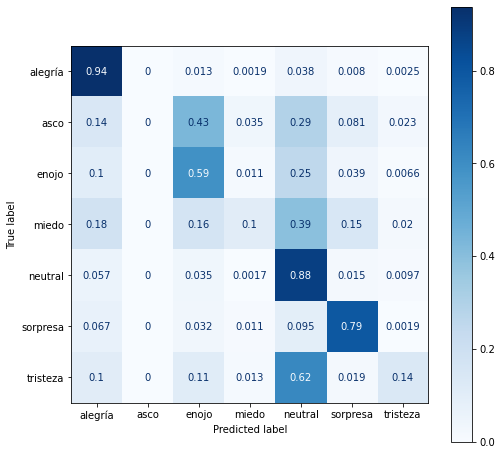

In [ ]:


fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(svm_classifiers[5], test_X, test_Y, cmap=plt.cm.Blues, normalize='true', ax=ax)

#### Decision Tree

[[474   3  41  24  25  24  12]
 [  0   0   0   0   0   1   0]
 [ 12   2  55  10  16   6   6]
 [  6   0   3   8   0   6   0]
 [ 65   3  49  52 324  43  53]
 [ 17   3  16  19  17 117  10]
 [  6   0   1   2   7   0   7]]


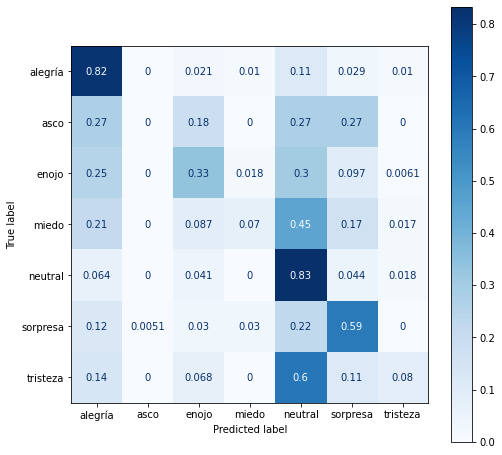

In [ ]:
print(get_confusion_matrix(decision_tree_predictions_gini[8]))

fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(decision_tree_classifiers_gini[8], test_X, test_Y, cmap=plt.cm.Blues, normalize='true', ax=ax)

#### Naive Bayes

[[287   0  18  12  17   5   6]
 [ 31   3   9   4  18   2   2]
 [ 46   3  54   8  43  16  14]
 [  6   0   2   3   2   6   2]
 [ 35   0  24  18  97   5  13]
 [ 98   3  36  54 150 154  21]
 [ 77   2  22  16  62   9  30]]


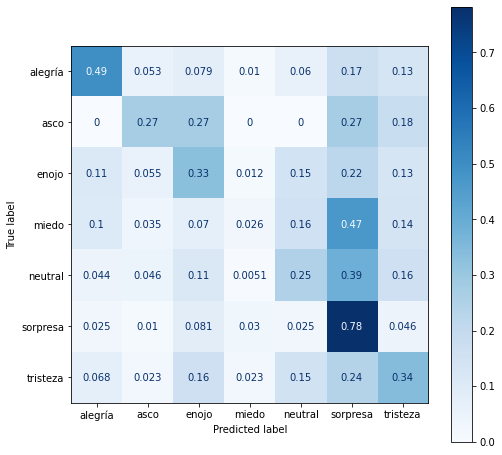

In [ ]:
print(get_confusion_matrix(naive_bayes_prediction))

fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(naive_bayes_classifier, test_X, test_Y, cmap=plt.cm.Blues, normalize='true', ax=ax)

### Análisis

De los tres clasificadores, aquel con el mejor resultado, fue SVM

El peor de los clasificadores fue Naive Bayes

## Parte 4

## Parte 5

## Parte 6